In [1]:
import os
import sys
# sys.path.append('/Users/wangqiqian/Desktop/TrafficTDApython/')
sys.path.append('C:/Users/USER/Desktop/TrafficTDApython/')

current_dir_path = os.getcwd()
current_file_path = os.path.abspath(current_dir_path)
current_dir_path = os.path.dirname(current_file_path)
parent_dir_path = os.path.dirname(current_dir_path)

os.chdir(current_dir_path + '\\ultils')
# os.chdir(current_dir_path + '/ultils')
print(current_dir_path)

import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import prince
import matplotlib.cm as cm
from matplotlib.cm import get_cmap
from matplotlib.font_manager import FontProperties

from sklearn.cluster import AgglomerativeClustering

from functions import *
from chi import *
from regressionP import *
from models import *
from utils_v3 import *
from plots import *

# os.chdir('/Users/wangqiqian/Desktop/TrafficTDApython/')
os.chdir('C:/Users/USER/Desktop/TrafficTDApython/')

from Version3.tdamapper.core_old import MapperAlgorithm
from Version3.tdamapper.cover import CubicalCover
from Version3.tdamapper.clustering import FailSafeClustering
from Version3.tdamapper.plot import MapperLayoutInteractive

# myfont = FontProperties(fname=r"/System/Library/Fonts/PingFang.ttc")
# sns.set(style="whitegrid", font=myfont.get_name())
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

c:\Users\USER\Desktop\TrafficTDApython


In [2]:
data1 = pd.read_csv("Data/NPA_TMA2_1.csv", low_memory=False)[:-2]
data2 = pd.read_csv("Data/NPA_TMA2_2.csv", low_memory=False)[:-2]
data3 = pd.read_csv("Data/NPA_TMA2_3.csv", low_memory=False)[:-2]
data4 = pd.read_csv("Data/NPA_TMA2_4_new.csv", low_memory=False)[:-2]
data5 = pd.read_csv("Data/NPA_TMA2_5.csv", low_memory=False)[:-2]
data6 = pd.read_csv("Data/NPA_TMA2_6_new.csv", low_memory=False)[:-2]
data7 = pd.read_csv("Data/NPA_TMA2_7.csv", low_memory=False)[:-2]
data8 = pd.read_csv("Data/NPA_TMA2_8.csv", low_memory=False)[:-2]
data9 = pd.read_csv("Data/NPA_TMA2_9.csv", low_memory=False)[:-2]
data10 = pd.read_csv("Data/NPA_TMA2_10.csv", low_memory=False)[:-2]

dataA2 = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9, data10], ignore_index=True)
# dataA2 = pd.concat([data1, data2, data3, data4, data5], ignore_index=True)

dataA1 = pd.read_csv("Data/NPA_TMA1_V3.csv")[:-2]

In [3]:
select_lst = [
    # 月份是為了篩選每個月2萬筆
    '發生月份',

    '天候名稱', '光線名稱', 
    '道路類別-第1當事者-名稱', '速限-第1當事者', 
    '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
    '號誌-號誌種類名稱', '號誌-號誌動作名稱',
    '車道劃分設施-分道設施-快車道或一般車道間名稱', '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱',
    '肇事逃逸類別名稱-是否肇逃',
    '死亡受傷人數',

    # 大類別
    '道路型態大類別名稱', '事故位置大類別名稱',
    '車道劃分設施-分向設施大類別名稱',
    '事故類型及型態大類別名稱', '當事者區分-類別-大類別名稱-車種', '當事者行動狀態大類別名稱',

    # 最初的值只有一種
    # '車輛撞擊部位大類別名稱-最初', 
    '車輛撞擊部位大類別名稱-其他',
    
    # 兩個相似且幾乎全部資料都一樣
    # '肇因研判大類別名稱-主要',
    # '肇因研判大類別名稱-個別',

    # 分析新增的
    # '事故類型及型態子類別名稱'
]
# select_lst = dataA1.columns

def preprocess(input_data, select_lst):
    # 篩選到第一個順位，因為注重的是單次事故的情況
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    sample_data = sample_data[sample_data['發生月份'] < 11]
    dataA = sample_data[select_lst]
    
    # 將資料分出死亡和受傷，合併到原本的資料後去除多餘的死亡受傷人數
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)
    # 補齊缺失值
    dist_df[select_lst] = dist_df[select_lst].fillna('未紀錄')

    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df

dist_dfA1 = preprocess(dataA1, select_lst)
dist_dfA2 = preprocess(dataA2, select_lst)

pass_A2 = dist_dfA2[dist_dfA2['當事者行動狀態大類別名稱'] == '人的狀態']
pass_A1 = dist_dfA1[dist_dfA1['當事者行動狀態大類別名稱'] == '人的狀態']

# drop
pass_A1.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)
pass_A2.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)

pass_A2 = pass_A2[pass_A2['行動電話或電腦或其他相類功能裝置名稱'] != '未紀錄']
pass_A1 = pass_A1[pass_A1['行動電話或電腦或其他相類功能裝置名稱'] != '未紀錄']
pass_A2 = pass_A2[pass_A2['行動電話或電腦或其他相類功能裝置名稱'] != '不明']
pass_A1 = pass_A1[pass_A1['行動電話或電腦或其他相類功能裝置名稱'] != '不明']

C:\Users\USER\AppData\Local\Temp\ipykernel_8688\4023374890.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pass_A1.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_8688\4023374890.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pass_A2.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)


In [4]:
# Concat
rbind_data = pd.concat([pass_A1, pass_A2], axis=0, ignore_index=True)
rbind_data.drop(columns=['發生月份'], inplace=True)
# rbind_data['速限_int'] = rbind_data['速限-第1當事者']
# rbind_data['年齡_int'] = rbind_data['當事者事故發生時年齡']

bins_age = [0, 14, 24, 34, 44, 54, 64, 74, float('inf')]
labels_age = ['未滿15歲', '15~24', '25~34', '35~44', '45~54', '55~64', '65~74', '75+']

rbind_data['當事者事故發生時年齡'] = pd.cut(rbind_data['當事者事故發生時年齡'], bins=bins_age, labels=labels_age, right=False)

rbind_data['當事者事故發生時年齡'] = rbind_data['當事者事故發生時年齡'].cat.add_categories('未知')
rbind_data['當事者事故發生時年齡'] = rbind_data['當事者事故發生時年齡'].fillna('未知')

bins_speed = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, float('inf')]
labels_speed = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '101-110', '110+']

rbind_data['速限-第1當事者'] = pd.cut(rbind_data['速限-第1當事者'], bins=bins_speed, labels=labels_speed, right=False)

# assert rbind_data.shape[0] == dist_dfA1.shape[0] + dist_dfA2.shape[0]
# Dummy
rbind_data["速限-第1當事者"] = rbind_data["速限-第1當事者"].astype(str)
dummy_data = pd.get_dummies(rbind_data)

print('dummy_data:', dummy_data.shape)

data_to_map = dummy_data.drop(['死亡', '受傷'], axis=1)
mapper_numpy = data_to_map.to_numpy()

dummy_data: (3117, 114)


In [5]:
output_file = 'C:/Users/USER/Desktop/TrafficTDApython/Version3/Gridsearch/Component12Pass/full_grid.pkl'

with open(output_file, 'rb') as f:
    detailed_results_df = pickle.load(f)

Mapper plot created.
Data extracted.
Colors mapped using predefined mapping.


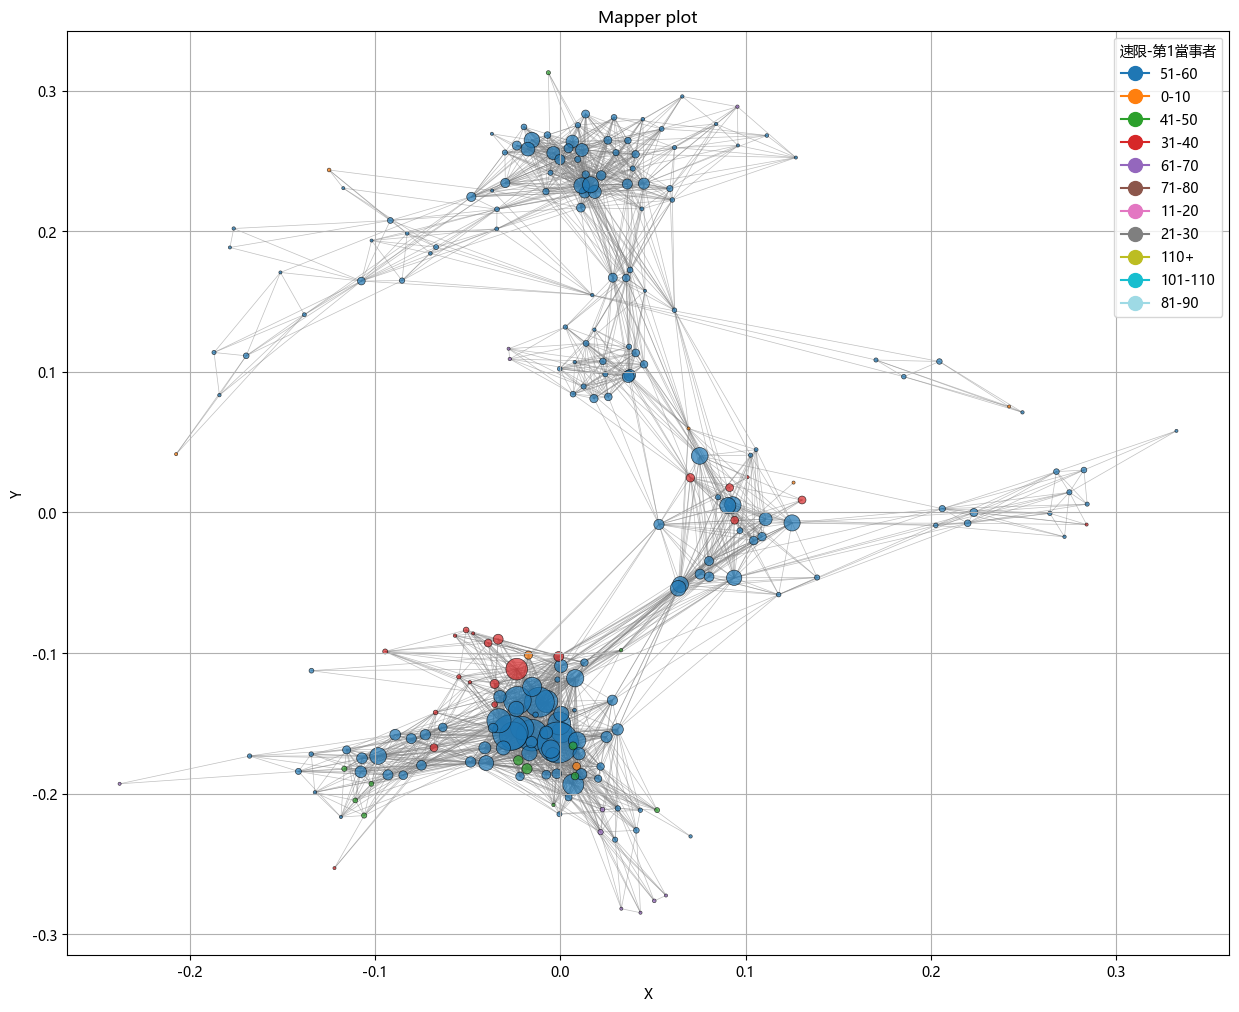

In [7]:
choose = '速限-第1當事者'

mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'].iloc[33][0], rbind_data, seed=10)
mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
full_info = mapper_plotter.extract_data()
mapper_plotter.map_colors(choose, size=4, threshold=0)
mapper_plotter.plot(choose, avg=False, set_label=True, size=100000)

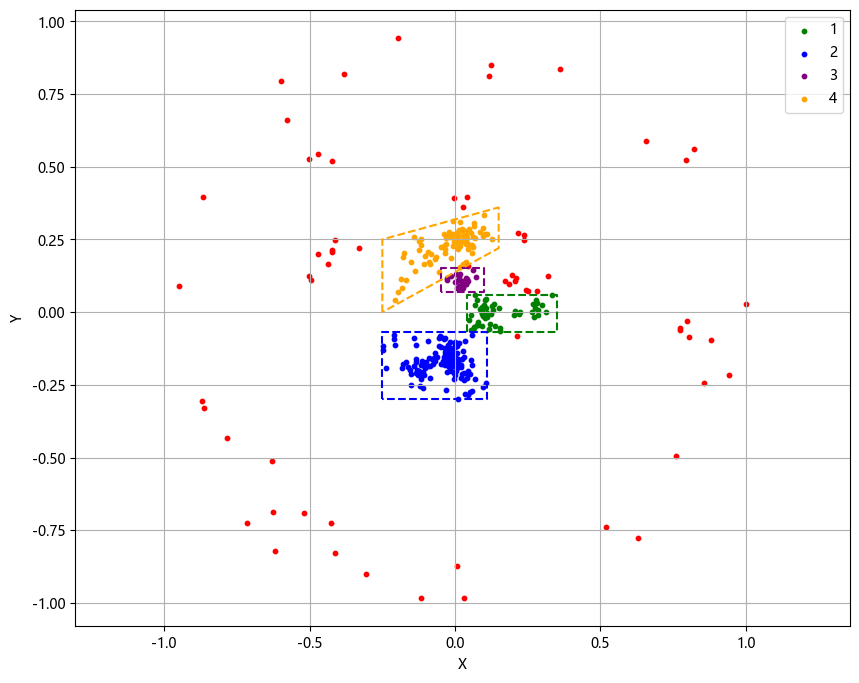

In [8]:
from shapely.geometry import Point, Polygon

rectangle1 = Polygon([(0.04, -0.07), (0.04, 0.06), (0.35, 0.06), (0.35, -0.07)])  # 矩形 1
rectangle2 = Polygon([(-0.25, -0.3), (-0.25, -0.07), (0.11, -0.07), (0.11, -0.3)])  # 矩形 2
rectangle3 = Polygon([(-0.05, 0.07), (-0.05, 0.15), (0.1, 0.15), (0.1, 0.07)]) 
rectangle4 = Polygon([(-0.25, 0), (-0.25, 0.25), (0.15, 0.36), (0.15, 0.22)]) 

# 限制會導致full_info的資料量減少
# filtered_full_info = full_info[full_info['size'] > 4]

# 檢查每個點是否在任意一個區塊內
inside_indices_1 = full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle1), axis=1)
inside_indices_2 = full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle2), axis=1)
inside_indices_3 = full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle3), axis=1)
inside_indices_4 = full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle4), axis=1)

label_0 = full_info[inside_indices_1]
label_1 = full_info[inside_indices_2]
label_2 = full_info[inside_indices_3]
label_3 = full_info[inside_indices_4]

# 提取區域內和區域外的數據
all_inside_indices = inside_indices_1 | inside_indices_2 | inside_indices_3 | inside_indices_4
outside_indices = ~all_inside_indices

label_out = full_info[outside_indices]

assert label_0.shape[0] + label_1.shape[0] 
+ label_2.shape[0] + label_3.shape[0] + label_out.shape[0] == full_info.shape[0]

# 繪製數據點和矩形區塊
plt.figure(figsize=(10, 8))
plt.scatter(label_0['x'], label_0['y'], label='1', color='green', s=10)
plt.scatter(label_1['x'], label_1['y'], label='2', color='blue', s=10)
plt.scatter(label_2['x'], label_2['y'], label='3', color='purple', s=10)
plt.scatter(label_3['x'], label_3['y'], label='4', color='orange', s=10)
plt.scatter(label_out['x'], label_out['y'], color='red', s=10)

# 繪製矩形區塊
for rect, color in zip([rectangle1, rectangle2, rectangle3, rectangle4], ['green', 'blue', 'purple', 'orange']):
    x, y = rect.exterior.xy
    plt.plot(x, y, color=color, linestyle='--')

# 圖形調整
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

In [20]:
# 獲取每個label的index
count_0 = get_unique_ids(label_0)
count_1 = get_unique_ids(label_1)
count_2 = get_unique_ids(label_2)
count_3 = get_unique_ids(label_3)

lst01 = sum(list(set(count_0) & set(count_1)))
lst02 = sum(list(set(count_0) & set(count_2)))
lst12 = sum(list(set(count_1) & set(count_2)))
lst03 = sum(list(set(count_0) & set(count_3)))
lst13 = sum(list(set(count_1) & set(count_3)))
lst23 = sum(list(set(count_2) & set(count_3)))

full_0 = dummy_data.loc[count_0].shape[0]
full_1 = dummy_data.loc[count_1].shape[0]
full_2 = dummy_data.loc[count_2].shape[0]
full_3 = dummy_data.loc[count_3].shape[0]



In [9]:
import openchord as ocd

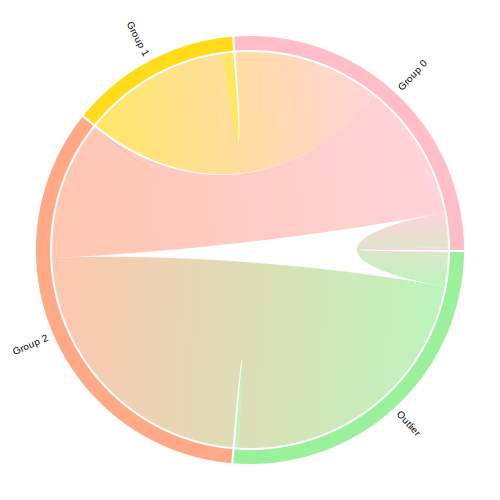

In [21]:
adjacency_matrix = [[full_0, lst01, lst02, lst03],
                    [lst01, full_1, lst12, lst13],
                    [lst02, lst12, full_2, lst23],
                    [lst03, lst13, lst23, full_3]]
labels = ['Group 0', 'Group 1', 'Group 2', 'Outlier']

fig = ocd.Chord(adjacency_matrix, labels)
fig.show()